In [51]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

from sklearn.datasets import load_iris
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import CategoricalNB 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# from IPython.display import Javascript
# def resize_colab_cell():
#   display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
# get_ipython().events.register('pre_run_cell', resize_colab_cell)

import warnings
warnings.filterwarnings("ignore")

# **Linear Regression Plan**

<!-- 

### Definition and Description
### Setting
### OLS
### Assumptions
### Dataset (one simple LR random generated X=Unif[-1,1], Y=X^3-x+noise, 
### one multiple LR https://www.kaggle.com/mirichoi0218/insurance), train-test split
### Fitting, summary, predictions
### Error metrics - MSE
### Error distribution
### Regularization - Ridge, Lasso, Elastic Net (lower priority)

-->

# LINEAR REGRESSION

In statistics, linear regression is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables). The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression. In linear regression, the relationships are modeled using linear predictor functions whose unknown model parameters are estimated from the data.

[Source](https://en.wikipedia.org/wiki/Linear_regression)

### Setting
Given a vector of independent variables, $x = (x_1, x_2, ..., x_n)$, we want to predict the vector of coefficients, $\beta = (\beta_0, \beta_1, ..., \beta_n)$, such that $\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$ can be used as a predictor for the independent variable, $y$. 

### Estimation - Ordinary Least Squares (OLS) Method
If we extend $x = (x_1, x_2, ..., x_n)$ to $x = (1, x_1, x_2, ..., x_n)$, then we are trying to approximate 
\begin{equation*}y \approx \beta \cdot x\end{equation*} 

In the OLS approach, the optimal parameter vector, $\hat{\beta}$, is given by (where m is the number of samples in the training set)
\begin{equation*} \hat{\beta} = \underset{\beta}{\operatorname{argmin}} \sum_{i=1}^{m} (y_i-\beta \cdot x_i)^2 \end{equation*}

Putting this in matrix format, we get
\begin{equation*} L(D,\beta) = \lvert Y-X\beta \rvert^2 \end{equation*}
\begin{equation*} L(D,\beta) = (Y-X\beta)^T(Y-X\beta) \end{equation*}
\begin{equation*} L(D,\beta) = Y^TY-Y^TX\beta-\beta^TX^TY+\beta^TX^TX\beta\end{equation*}

Since the loss function, $L(D, \beta)$, is convex, the minimum value is reached by equating the gradient to 0.<br><br>
\begin{equation*} \frac{\partial L(D,\beta)}{\partial \beta} = -2Y^TX+2\beta^TX^TX = 0 \end{equation*}
\begin{equation*} \beta = (X^TX)^{-1}X^TY \end{equation*}

### Assumptions
The following are the assumptions made by linear regression models with standard estimation techniques -
1. Weak Exogenity - This essentially means that the model assumes that the predictor variables are error-free, or that they are exact, and not random variables. 
2. Homoscedasticity - This means that the model assumes that the varaince in the error terms is constant, and does not vary across different values of predictor variables. In practice, this assumption rarely ever holds, i.e., error are terms are heteroscedastic. Heteroscedasticity will mean that the different values of the varaince are averaged to get a single variance, which inaccurately represents the variance of the error along the line. Typically, this means that the response variable with higher mean is likely to have a higher variance. Take for example a regression model trying to predict a person's salary. A prediction of 100,000 can have a variance of 20,000, but a prediction of 10,000 is less likelier to have the same varaince. This leads to less precise parameter estimates and incorrect metric scores.
3. Independence of Errors - The error terms are assumed to be independent of each other. Bayesian linear regression is useful for handling correlated errors.
4. Lack of perfect multicollinearity in the predictors - This assumption implies that the design matrix X, must be full rank. In the case of perfect collinearity, the parameter vector, $\beta$ cannot be uniquely predicted.

### Synthetic Dataset

We first make a synthetic dataset, and will use this to compare the power of linear regressino and polynomial regression (next section).

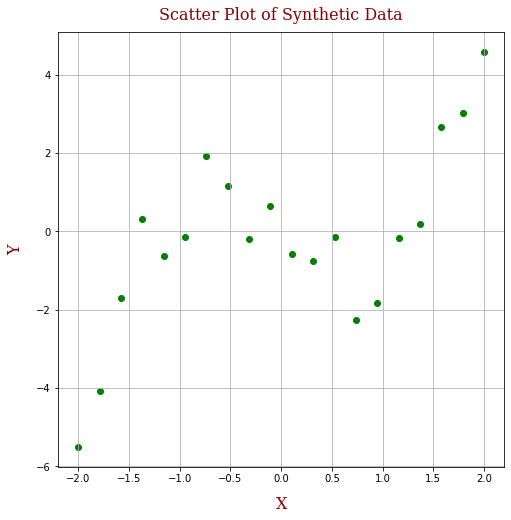

In [3]:
np.random.seed(42)

start, end, num_points = -2, 2, 20

def get_Y(f, X, error=True):
    return f(X) + (np.random.normal(0, 1, X.shape[0]) if error else 0)

synthetic_X = np.linspace(start, end, num_points)
synthetic_Y = get_Y(lambda x: x**3 - x, synthetic_X)

fontdict = {"family":"serif", "color":"darkred", "weight":"normal", "size":16}
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
plt.scatter(synthetic_X, synthetic_Y, color='g')
ax.set_title("Scatter Plot of Synthetic Data", fontdict=fontdict, pad=12)
ax.set_xlabel("X", fontdict=fontdict, labelpad=12)
ax.set_ylabel("Y", fontdict=fontdict, labelpad=12)
ax.grid()

In [4]:
linear_model = sm.OLS(synthetic_Y, sm.tools.tools.add_constant(synthetic_X))
result = linear_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     11.82
Date:                Wed, 29 Sep 2021   Prob (F-statistic):            0.00294
Time:                        19:04:45   Log-Likelihood:                -39.620
No. Observations:                  20   AIC:                             83.24
Df Residuals:                      18   BIC:                             85.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1713      0.413     -0.414      0.6

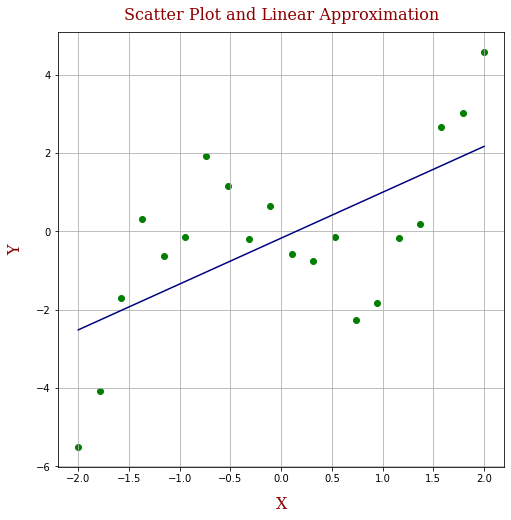

In [5]:
fontdict = {"family":"serif", "color":"darkred", "weight":"normal", "size":16}
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
plt.scatter(synthetic_X, synthetic_Y, color='g')
plt.plot(synthetic_X, get_Y(lambda x: result.params[0] + x*result.params[1], synthetic_X, error=False), color='navy')
ax.set_title("Scatter Plot and Linear Approximation", fontdict=fontdict, pad=12)
ax.set_xlabel("X", fontdict=fontdict, labelpad=12)
ax.set_ylabel("Y", fontdict=fontdict, labelpad=12)
ax.grid()

### Import Dataset
We are going to use the Medical Cost dataset from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/ignasa007/Machine-Learning-Tutorials/main/data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df.age.min(), df.age.max()

(18, 64)

In [8]:
df["14<Age<25"] = df["age"].apply(lambda x: 1 if 14<x<25 else 0)
df["24<Age<35"] = df["age"].apply(lambda x: 1 if 24<x<35 else 0)
df["34<Age<45"] = df["age"].apply(lambda x: 1 if 34<x<45 else 0)
df["44<Age<55"] = df["age"].apply(lambda x: 1 if 44<x<55 else 0)
df["54<Age<65"] = df["age"].apply(lambda x: 1 if 54<x<65 else 0)
df.drop(columns=["age"], inplace=True)

df["Male"] = df["sex"].apply(lambda x: 1 if x=="male" else 0)
df["Female"] = df["sex"].apply(lambda x: 1 if x=="female" else 0)
df.drop(columns=["sex"], inplace=True)

df["Smoker"] = df["smoker"].apply(lambda x: 1 if x=="yes" else 0)
df["Non-Smoker"] = df["smoker"].apply(lambda x: 1 if x=="no" else 0)
df.drop(columns=["smoker"], inplace=True)

df.drop(columns=["children", "region"], inplace=True)

df.head()

,bmi,charges,14<Age<25,24<Age<35,34<Age<45,44<Age<55,54<Age<65,Male,Female,Smoker,Non-Smoker
0,27.900,16884.92400,1,0,0,0,0,0,1,1,0
1,33.770,1725.55230,1,0,0,0,0,1,0,0,1
2,33.000,4449.46200,0,1,0,0,0,1,0,0,1
3,22.705,21984.47061,0,1,0,0,0,1,0,0,1
4,28.880,3866.85520,0,1,0,0,0,1,0,0,1


The intuition behind making columns for age groups is that the cost of a medical procedure does not depend on the age of a person. However, young and old people have weaker bodies, which can increase the complexity of procedures. Hence, it is assumed that people in different age groups can have different levels of dependence of medical charges on age.

In [9]:
mask = np.random.uniform(0, 1, len(df)) < 0.8
train_df = df[mask]
test_df = df[~mask]

train_df.shape, test_df.shape

((1060, 11), (278, 11))

In [10]:
x_train, y_train = train_df[train_df.columns.difference(["charges"])], train_df.charges
x_train.shape, y_train.shape

((1060, 10), (1060,))

In [11]:
linear_model = sm.OLS(y_train, sm.tools.tools.add_constant(x_train))
result = linear_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     453.4
Date:                Wed, 29 Sep 2021   Prob (F-statistic):          2.08e-312
Time:                        19:04:50   Log-Likelihood:                -10717.
No. Observations:                1060   AIC:                         2.145e+04
Df Residuals:                    1052   BIC:                         2.149e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4620.2824    435.090     10.619      0.0

In [12]:
x_test, y_test = test_df[test_df.columns.difference(["charges"])], test_df.charges
x_test.shape, y_test.shape

((278, 10), (278,))

In [13]:
predictions = result.predict(sm.tools.tools.add_constant(x_test))
pd.DataFrame({'predictions': predictions, 'true value': y_test})

,predictions,true value
9,12369.382921,28923.13692
10,4146.026527,2721.32080
11,36387.291537,27808.72510
19,31008.261597,36837.46700
26,11461.373723,14451.83515
...,...,...
1324,4052.094541,4239.89265
1326,8327.385636,7050.02130
1331,4835.862604,10795.93733
1332,15500.317781,11411.68500


## Error Metrics

### Mean Absolute Error 
Mean Absolute Error (MAE) is defined as the average difference between the true values (y) and predicted values ($\hat{y}$). It summarizes performance in a way that disregards the direction of over- or under- prediction. It is a negatively oriented score, i.e., lower the value, better is the performance of the model.

### Root Mean Squared Error
Root Mean Squared Error (RMSE) is defined as the square root of the average of squared distance between the true values (y) and predicted values ($\hat{y}$). Like MAE, it summarizes performance in a way that disregards the direction of over- or under- prediction. RMSE is more sensitive to outliers than MAE, i.e., RMSE is more affected by predictions which drastically vary from the true values. RMSE increases with the variance of the frequency distribution of error magnitudes. Again, like MAE, it is a negatively oriented score. RMSE can be a better score for evaluating the model if large errors are particularly undesirable.

### R2 Score
The coefficient of determination, denoted as $R^2$, and pronounced as "R squared", is the fraction of variance in the dependent variable that is explained by the independent variables (regressors). It measures how well the model replicates the observed values, based on the proportion of total variation explained by the model. It is calculated as <br>
\begin{equation*} R^2 = 1-\frac{\sum_{i} (y_i-\hat {y})^2}{\sum_{i} (y_i-\overline {y})^2} \end{equation*}

$R^2$ can vary anywhere in the range $(-\inf, 1]$. Higher the value of $R^2$, higher is the explainability of the model. 

In [14]:
print("\033[1m" + "\033[4m" + "LINEAR REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

LINEAR REGRESSION

Mean Absolute Error = 4661.1474
Root Mean Squared Error = 6720.5361
R2 Score = 0.7204


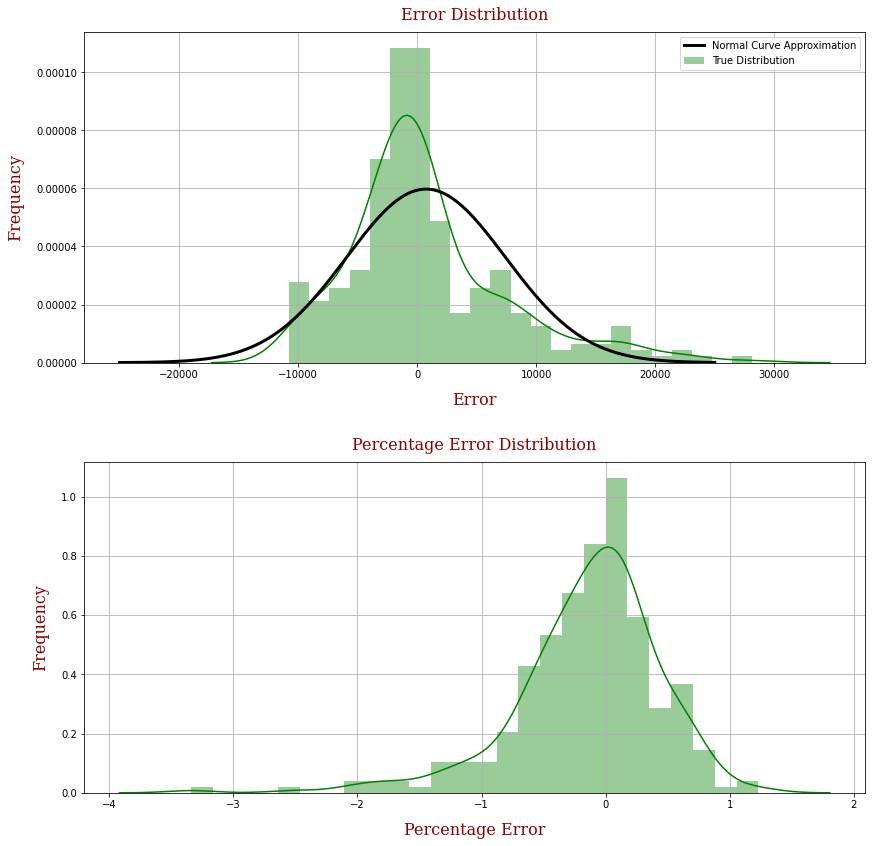

In [15]:
fontdict = {"family":"serif", "color":"darkred", "weight":"normal", "size":16}
x = np.linspace(-25000, 25000, 100000)
plt.figure(figsize=(14, 14))

errors = y_test-predictions
ax = plt.subplot(211)
plot = sns.distplot(errors, color="green", label="True Distribution")
ax.plot(x, stats.norm.pdf(x, np.mean(errors), np.std(errors)), linewidth=3, color="black", label="Normal Curve Approximation")
plot.set_title("Error Distribution", fontdict=fontdict, pad=12)
plot.set_xlabel("Error", fontdict=fontdict, labelpad=12)
plot.set_ylabel("Frequency", fontdict=fontdict, labelpad=12)
ax.grid()
ax.legend()

percentage_error = 1-predictions/y_test
ax = plt.subplot(212)
plot = sns.distplot(percentage_error, color="green")
plot.set_title("Percentage Error Distribution", fontdict=fontdict, pad=12)
plot.set_xlabel("Percentage Error", fontdict=fontdict, labelpad=12)
plot.set_ylabel("Frequency", fontdict=fontdict, labelpad=12)
ax.grid()

plt.subplots_adjust(hspace=0.3)

### Note
In cases where the independent variables suffer from multicolinearity (highly correlated inpdependent variables), even though the least squares estimates are unbiased, they suffer from high variance. This leads to observed value often deviating largely from the true value. The standard errors can be reduced by adding a degree of bias.<br>
In linear regression, the prediction errors, $e = y-\hat{y}$, can be decomposed into two sub components - due to <b>bias</b> in the estimators and due to <b>varaince</b> in them. Assuming the estimators to be unbiased, there are three ways to reduce the varaince in them - Ridge, Lasso and ElasticNet Regularization.

## Ridge Regularization

Ridge regression solves the multicollinearity problem by using a shrinkage parameter, $\lambda$, to add a term to the loss function.

\begin{equation*} L(D,\beta) = \left(Y-\lvert X\beta \rvert^2 \right) + \lambda \lvert \beta \rvert_2^2 \end{equation*}

\begin{equation*} \hat{\beta} = \underset{\beta \in R^p}{\operatorname{argmin}} L(D,\beta) \end{equation*}

The second term is simply $\lambda$ times the squared Frobenius Norm of the coefficient vector.

The assumptions of this regression is same as least squared regression except normality is not to be assumed.

In [16]:
ridge = Ridge(alpha=1.0)
ridge.fit(x_train, y_train)
predictions = ridge.predict(x_test)

print("\033[1m" + "\033[4m" + "RIDGE REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

RIDGE REGRESSION

Mean Absolute Error = 4665.1223
Root Mean Squared Error = 6721.8465
R2 Score = 0.7203


In [17]:
x_train.iloc[:5,:]

,14<Age<25,24<Age<35,34<Age<45,44<Age<55,54<Age<65,Female,Male,Non-Smoker,Smoker,bmi
0,1,0,0,0,0,1,0,0,1,27.900
1,1,0,0,0,0,0,1,1,0,33.770
2,0,1,0,0,0,0,1,1,0,33.000
3,0,1,0,0,0,0,1,1,0,22.705
4,0,1,0,0,0,0,1,1,0,28.880


In [18]:
print(ridge.coef_, "\n")
print(ridge.intercept_)
assert ridge.predict(x_train.iloc[:5,:]).all() == (np.dot(x_train.iloc[:5,:], ridge.coef_) + ridge.intercept_).all()

[ -4480.05798063  -2612.89502353   -827.26505185   2427.82276828
   5492.39528773     96.5695085     -96.5695085  -11898.59017522
  11898.59017522    329.89081887] 

10132.99365756769


## Lasso Regularization

Similar to Ridge Regression, Lasso (Least Absolute Shrinkage and Selection Operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models.

\begin{equation*} L(D,\beta) = \lvert Y-X\beta \rvert^2 + \lambda \lvert \beta \rvert_1 \end{equation*}

\begin{equation*} \hat{\beta} = \underset{\beta \in R^p}{\operatorname{argmin}} L(D,\beta) \end{equation*}

Lasso regression varies from Ridge regression in the sense that it uses the L1 norm of the coefficient vector, instead of the squared Frobenius norm, in the loss function. The loss function is effective in reducing some of the parameter values to 0. Larger the value of $\lambda$, more is the reduction effect. This results to feature selection from given variables. 

The assumptions of this regression is same as least squared regression except normality is not to be assumed.
If group of predictors are highly correlated, lasso picks only one of them and shrinks the others to zero.

In [19]:
lasso = Lasso(alpha=1.0)
lasso.fit(x_train, y_train)
predictions = lasso.predict(x_test)

print("\033[1m" + "\033[4m" + "LASSO REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

LASSO REGRESSION

Mean Absolute Error = 4661.5124
Root Mean Squared Error = 6720.825
R2 Score = 0.7204


# **Polynomial Regression Plan**

<!--

### Description
### Analysis with different complexities of curves (degree) on custom example dataset and a real dataset

-->

# POLYNOMIAL REGRESSION

In statistics, polynomial regression is a form of regression analysis in which the relationship test between the independent variable <b>x</b> and the dependent variable <b>y</b> is modelled as an nth degree polynomial in <b>x</b>. 

\begin{equation*} \hat{y} = \beta_0 + (\beta_{11}x_1^1 + \beta_{12}x_1^2 + ... + \beta_{1n}x_1^n) + (\beta_{21}x_2^1 + \beta_{22}x_2^2 + ... + \beta_{2n}x_2^n) + ... + (\beta_{m1}x_m^1 + \beta_{m2}x_m^2 + ... + \beta_{mn}x_m^n) \end{equation*}

\begin{equation*} \hat{y} = \beta_0 + \sum_{i=1}^m \sum_{j=1}^n \beta_{ij} x_i^j \end{equation*}

Polynomial regression fits a nonlinear relationship between the value of <b>x</b> and the corresponding conditional mean of <b>y</b>, denoted $E(y|x)$. Although polynomial regression fits a nonlinear model to the data, <b>as a statistical estimation problem it is linear</b>, in the sense that the regression function $E(y|x)$ is <b>linear in the unknown parameters</b> that are estimated from the data. For this reason, polynomial regression is considered to be a special case of multiple linear regression.

Predicting a nonlinear model in the input features is the same as predicting a linear model in the transformed input features -

\begin{equation*} x' = (x_1^1, x_1^2, ..., x_1^n, x_2^1, x_2^2, ..., x_2^n, ..., x_m^1, x_m^2, ..., x_m^n) \end{equation*}

In [20]:
def polynomial_regression(x_train, x_test, y_train, y_test, degree=1):

    if len(x_train.shape) == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)

    polynomial_features = PolynomialFeatures(degree=degree)
    x_train_transform = polynomial_features.fit_transform(x_train)
    x_test_transform = polynomial_features.fit_transform(x_test)

    lr_model = LinearRegression()
    lr_model.fit(x_train_transform, y_train)
    predictions_poly = lr_model.predict(x_test_transform)

    print("\033[1m" + "\033[4m" + f"POLYNOMIAL REGRESSION, DEGREE={degree}" + "\033[0m" + "\n")
    print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions_poly), 4))
    print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions_poly, squared=False), 4))
    print("R2 Score =", round(r2_score(y_test, predictions_poly), 4), end='\n\n')

    return polynomial_features, lr_model

In [21]:
x_train, x_test, y_train, y_test = train_test_split(synthetic_X, synthetic_Y, test_size=0.2)
x_train.shape, x_test.shape

((16,), (4,))

POLYNOMIAL REGRESSION, DEGREE=1

Mean Absolute Error = 1.3278
Root Mean Squared Error = 1.4051
R2 Score = -26.9714

POLYNOMIAL REGRESSION, DEGREE=2

Mean Absolute Error = 1.4121
Root Mean Squared Error = 1.4633
R2 Score = -29.3373

POLYNOMIAL REGRESSION, DEGREE=3

Mean Absolute Error = 0.4993
Root Mean Squared Error = 0.6253
R2 Score = -4.5393

POLYNOMIAL REGRESSION, DEGREE=4

Mean Absolute Error = 0.4503
Root Mean Squared Error = 0.6063
R2 Score = -4.2076

POLYNOMIAL REGRESSION, DEGREE=5

Mean Absolute Error = 0.6167
Root Mean Squared Error = 0.8135
R2 Score = -8.3757

POLYNOMIAL REGRESSION, DEGREE=6

Mean Absolute Error = 0.6565
Root Mean Squared Error = 0.8632
R2 Score = -9.5579



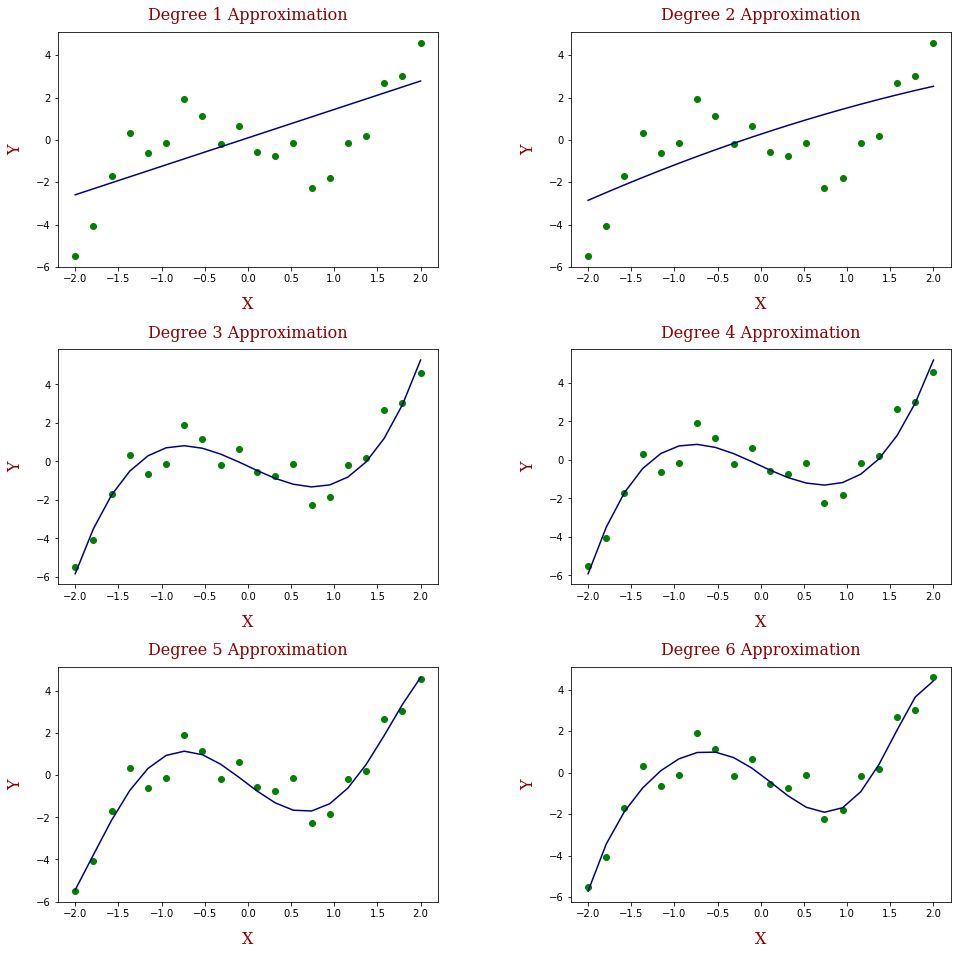

In [22]:
fontdict = {"family": "serif", "color": "darkred", "weight": "normal", "size": 16}
fig, axs = plt.subplots(3, 2, figsize=(16,16))
plt.subplots_adjust(hspace=0.35, wspace=0.35)

for degree in range(1, 7):

    polynomial_features, lr_model = polynomial_regression(x_train, x_test, y_train, y_test, degree=degree)
    
    axs[(degree-1)//2, 1-degree%2].scatter(synthetic_X, synthetic_Y, color='g')
    axs[(degree-1)//2, 1-degree%2].plot(synthetic_X, lr_model.predict(polynomial_features.fit_transform(synthetic_X.reshape(-1, 1))), color='navy')
    axs[(degree-1)//2, 1-degree%2].set_title(f"Degree {degree} Approximation", fontdict=fontdict, pad=12)
    axs[(degree-1)//2, 1-degree%2].set_xlabel("X", fontdict=fontdict, labelpad=12)
    axs[(degree-1)//2, 1-degree%2].set_ylabel("Y", fontdict=fontdict, labelpad=12)

### Working with real data
We are going to use the wine dataset available [here](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009).

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/ignasa007/Machine-Learning-Tutorials/main/data/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Since quality is a categorical varaible, we will predict the ph value using other variables.

In [24]:
df.drop(["quality"], axis=1, inplace=True)
x_df, y_df = df[df.columns.difference(["pH"])], df[["pH"]]
x_values, y_values = x_df.values, y_df.values
x_df.head()

,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,9.4,0.076,0.00,0.9978,7.4,11.0,1.9,0.56,34.0,0.70
1,9.8,0.098,0.00,0.9968,7.8,25.0,2.6,0.68,67.0,0.88
2,9.8,0.092,0.04,0.9970,7.8,15.0,2.3,0.65,54.0,0.76
3,9.8,0.075,0.56,0.9980,11.2,17.0,1.9,0.58,60.0,0.28
4,9.4,0.076,0.00,0.9978,7.4,11.0,1.9,0.56,34.0,0.70


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2, random_state=1)
x_train.shape, x_test.shape

((1279, 10), (320, 10))

In [26]:
for degree in range(1, 4):
    _, _ = polynomial_regression(x_train, x_test, y_train, y_test, degree=degree)

POLYNOMIAL REGRESSION, DEGREE=1

Mean Absolute Error = 0.0643
Root Mean Squared Error = 0.0815
R2 Score = 0.6748

POLYNOMIAL REGRESSION, DEGREE=2

Mean Absolute Error = 0.0582
Root Mean Squared Error = 0.074
R2 Score = 0.7316

POLYNOMIAL REGRESSION, DEGREE=3

Mean Absolute Error = 0.0613
Root Mean Squared Error = 0.1091
R2 Score = 0.4176



# **Naive Bayes Plan**

<!--

### Bayes Theorem
### Definition and Description with a small example
### Custom dataset https://www.saedsayad.com/naive_bayesian.htm
### Algorithm

-->



# NAIVE BAYES

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.

## Implementation

Let’s use the famous Flu dataset for naive Bayes and import it, you can change the path. You can download the data from [here]().

In [27]:
flu = pd.read_csv('https://raw.githubusercontent.com/ignasa007/Machine-Learning-Tutorials/main/data/flu.csv')
flu.head()

,Chills,runny nose,head ache,fever,Flu
0,Y,N,Mild,Y,N
1,Y,Y,No,N,Y
2,Y,N,Strong,Y,Y
3,N,Y,Mild,Y,Y
4,N,N,No,N,N


In [28]:
# Collecting the Variables
x1 = flu.iloc[:,0]
x2 = flu.iloc[:,1]
x3 = flu.iloc[:,2]
x4 = flu.iloc[:,3]
y = flu.iloc[:,4]

# Encoding the categorical variables
le = LabelEncoder()
x1 = le.fit_transform(x1)
x2 = le.fit_transform(x2)
x3 = le.fit_transform(x3)
x4 = le.fit_transform(x4)
y = le.fit_transform(y)

# Getting the Encoded in Data Frame
X = pd.DataFrame(list(zip(x1,x2,x3,x4)), columns=flu.columns.difference(['Flu']))
X.head()

,Chills,fever,head ache,runny nose
0,1,0,0,1
1,1,1,1,0
2,1,0,2,1
3,0,1,0,1
4,0,0,1,0


Now we fit the Naive Bayes classifier to the data and predict probability of flu for a patient with chills, but no fever, a mild head ache and a runny nose

In [29]:
model = CategoricalNB()

# Train the model using the training sets
model.fit(X,y)

# ['Y','N','Mild','Y']
predicted = model.predict([[1,0,0,1]]) 
print('Predicted Value:', model.predict([[1,0,0,1]]))
preds = model.predict_proba([[1,0,0,1]])[0]
print(*[f'Pr(class={i}) = {round(preds[i], 4)}' for i in range(preds.shape[0])], sep=', ')

Predicted Value: [1]
Pr(class=0) = 0.3051, Pr(class=1) = 0.6949


The model suggests that the probability of the patient having flue is 0.695

# **Decision Trees Plan**

<!--
### Entropy (optional)
### Information Gain (optional) or Accuracy
### Splitting example over a node, how to select which feature
### Pros-Cons
### Implementation https://archive.ics.uci.edu/ml/datasets/iris, Visualization
-->

# Decision Treees

Decision Tree algorithm belongs to the family of supervised learning algorithms. The goal of using a Decision Tree is to create a training model that can use to predict the class or value of the target variable by learning simple decision rules inferred from prior data. 

In Decision Trees, for predicting a class label for a record we start from the root of the tree. We compare the values of the root attribute with the record’s attribute. On the basis of comparison, we follow the branch corresponding to that value and jump to the next node.

## Important Terminology related to Decision Trees

**Root Node**: It represents the entire population or sample and this further gets divided into two or more homogeneous sets. <br>
**Splitting**: It is a process of dividing a node into two or more sub-nodes. <br>
**Decision Node**: When a sub-node splits into further sub-nodes, then it is called the decision node. <br>
**Leaf / Terminal Node**: Nodes do not split is called Leaf or Terminal node. <br>
**Pruning**: When we remove sub-nodes of a decision node, this process is called pruning. You can say the opposite process of splitting. <br>
**Branch / Sub-Tree**: A subsection of the entire tree is called branch or sub-tree. <br>
**Parent and Child Node**: A node, which is divided into sub-nodes is called a parent node of sub-nodes whereas sub-nodes are the child of a parent node. <br>

![](assets/decision_trees.png)

## How do Decision Trees work?
 
The decision of making strategic splits heavily affects a tree’s accuracy. The decision criteria are different for classification and regression trees.

Decision trees use multiple algorithms to decide to split a node into two or more sub-nodes. The creation of sub-nodes increases the homogeneity of resultant sub-nodes. In other words, we can say that the purity of the node increases with respect to the target variable. The decision tree splits the nodes on all available variables and then selects the split which results in most homogeneous sub-nodes.

### **ID3 algorithm**:

1. It begins with the original set S as the root node.
2. On each iteration of the algorithm, it iterates through the very unused attribute of the set S and calculates Entropy (H) and Information gain (IG) of this attribute.
3. It then selects the attribute which has the smallest Entropy or Largest Information gain.
4. The set S is then split by the selected attribute to produce a subset of the data.
5. The algorithm continues to recur on each subset, considering only attributes never selected before.

## Entropy

Entropy of a probability distribution is calculated as
$$
H(X) = -\sum_{i=1}^{n} P_i\log_b{P_i}
$$
where $n$ is the number of classes $X$ can belong to, and $P_i = Pr(X=i)$.

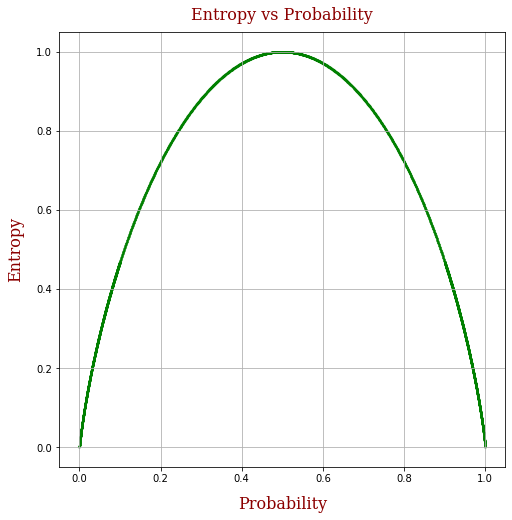

In [46]:
var = 0.1

entropy_X = np.concatenate((np.linspace(0, var, 1500), np.linspace(var, 1-var, 2000), np.linspace(1-var, 1, 1500)))
entropy_Y = - (entropy_X * np.log2(entropy_X) + (1-entropy_X) * np.log2(1-entropy_X))

fontdict = {"family":"serif", "color":"darkred", "weight":"normal", "size":16}
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
plt.scatter(entropy_X, entropy_Y, color='g', s=1)
ax.set_title("Entropy vs Probability", fontdict=fontdict, pad=12)
ax.set_xlabel("Probability", fontdict=fontdict, labelpad=12)
ax.set_ylabel("Entropy", fontdict=fontdict, labelpad=12)
ax.grid()

Above is a plot in case of a two class problem of entropy against the probability of the random variable belonging to one of the classes. From the graph we see that $P_i = 0.5$ gives the highest entropy and it decreases towards the extremes. This can be understood by viewing entropy as a measure of randomness. As $P_i$ approaches 0 or 1, the randomness in the result decreases and we can make a guess about the value of the variable with high accuracy. Similarly, if $P_i = 0.5$, the uncertainity in the result is highest and our prediction has the highest likelihood of being wrong.

## Information Gain

Information gain or IG is a statistical property that measures how well a given attribute separates the training examples according to their target classification. Constructing a decision tree is all about finding an attribute that returns the highest information gain and the smallest entropy. Information gain is a decrease in entropy. It computes the difference between entropy before split and average entropy after split of the dataset based on given attribute values.

![](assets/information_gain.png)

In [50]:
FEATURE_NAMES = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

iris = load_iris()
iris_X = pd.DataFrame(iris.data, columns = FEATURE_NAMES)
iris_y = iris.target

model = DecisionTreeClassifier()
model.fit(iris_X, iris_y)

DecisionTreeClassifier()

In [52]:
export_graphviz(model, './assets/tree.dot', feature_names = FEATURE_NAMES)
! dot -Tpng assets/tree.dot -o assets/tree.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


# **Ensemble Methods**
### Description, need
### Weak learner, strong learner
### Boosting
### Examples

# **Random Forest**
### Description
### Bagging
### Implementation https://archive.ics.uci.edu/ml/datasets/iris
### Visualization (?)

# **AdaBoost**
### Description + Manual implementation
### sklearn implementation

# **Boost by Majority**
### (optional)